# Telco Customer Churn Prediction

## pipeline:
1. Предобработка данных и разметка
2. Отбор признаков (`select_features`)
3. Поиск лучшей итерации с помощью кросс-валидации
4. Обучение модели
5. Подбор оптимального порога по F1
6. ROC-кривая и метрики качества

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, recall_score, f1_score, auc, roc_curve

from catboost import CatBoostClassifier, Pool, cv,EFeaturesSelectionAlgorithm, EShapCalcType

## Загрузка данных

In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Основная информация по датасету

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Выделение категориальных и числовых признаков

In [ ]:
ID = ['customerID']
TARGET = ['Churn']
NOISE = ['PhoneService', 'Partner']

categorical = [
    i
    for i in df.columns
    if df[i].dtype == 'object' and i not in ID and i not in TARGET and i not in NOISE
]

numerical = [
    i
    for i in df.columns
    if df[i].dtype !='object' and i not in ID and i not in TARGET
]

## Формирование X и y

In [ ]:
X = df.drop(columns=['customerID', 'Churn', 'PhoneService', 'Partner'])

y = df['Churn'].map({'No':0, 'Yes':1})

## Разбиение на train и test выборки



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Инициализируем pools

In [ ]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorial)

test_pool = Pool(data=X_test, label=y_test, cat_features=categorial)

## Отбираем признаки

In [ ]:
cb_for_select = CatBoostClassifier(
    random_seed=1234,
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=100,
    depth=6,
    learning_rate=0.01,
    early_stopping_rounds=50,
    auto_class_weights='Balanced'
)

result = cb_for_select.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(len(train_pool.get_feature_names()))),
    num_features_to_select=10,  # Сколько фич оставить
    steps=10,  # Шаг отбора (по сколько фич удалять за итерацию)
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    plot=False,
    verbose=True
)

The number of features selection steps (10) is greater than the number of features to eliminate (7). The number of steps was reduced to 7.


Step #1 out of 7
0:	test: 0.8150605	best: 0.8150605 (0)	total: 210ms	remaining: 20.8s
1:	test: 0.8291505	best: 0.8291505 (1)	total: 251ms	remaining: 12.3s
2:	test: 0.8425017	best: 0.8425017 (2)	total: 303ms	remaining: 9.79s
3:	test: 0.8403566	best: 0.8425017 (2)	total: 344ms	remaining: 8.26s
4:	test: 0.8392794	best: 0.8425017 (2)	total: 385ms	remaining: 7.31s
5:	test: 0.8388243	best: 0.8425017 (2)	total: 426ms	remaining: 6.67s
6:	test: 0.8378015	best: 0.8425017 (2)	total: 482ms	remaining: 6.4s
7:	test: 0.8384021	best: 0.8425017 (2)	total: 510ms	remaining: 5.86s
8:	test: 0.8404852	best: 0.8425017 (2)	total: 550ms	remaining: 5.57s
9:	test: 0.8432955	best: 0.8432955 (9)	total: 587ms	remaining: 5.29s
10:	test: 0.8416609	best: 0.8432955 (9)	total: 626ms	remaining: 5.06s
11:	test: 0.8409093	best: 0.8432955 (9)	total: 665ms	remaining: 4.87s
12:	test: 0.8400582	best: 0.8432955 (9)	total: 698ms	remaining: 4.67s
13:	test: 0.8399456	best: 0.8432955 (9)	total: 735ms	remaining: 4.51s
14:	test: 0.83

## Обновление train и test выборок

In [ ]:
sel_f = result['selected_features_names']

X_train_sel = X_train[sel_f]
X_test_sel = X_test[sel_f]
cat_f = [f for f in sel_f if f in categorical]

## Обновление pools

In [ ]:
train_pool_sel = Pool(data=X_train_sel, label=y_train, cat_features=cat_f)
test_pool_sel = Pool(data=X_test_sel, label=y_test, cat_features=cat_f)

## Кросс-валидация для выбора лучшей итерации

In [ ]:
params = {
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'iterations':1000,
    'depth':6,
    'learning_rate':0.01,
    'early_stopping_rounds':50
}

cv_result = cv(train_pool_sel, params= params, fold_count=5,early_stopping_rounds=50, plot=True)

best_iteration = cv_result['test-AUC-mean'].idxmax()

print(f'Лучшая итерация по метрике ROC AUC:{best_iteration}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	test: 0.7790299	best: 0.7790299 (0)	total: 37.4ms	remaining: 37.4s
1:	test: 0.8243549	best: 0.8243549 (1)	total: 74.9ms	remaining: 37.4s
2:	test: 0.8228748	best: 0.8243549 (1)	total: 117ms	remaining: 38.9s
3:	test: 0.8262216	best: 0.8262216 (3)	total: 139ms	remaining: 34.7s
4:	test: 0.8296491	best: 0.8296491 (4)	total: 184ms	remaining: 36.6s
5:	test: 0.8289826	best: 0.8296491 (4)	total: 232ms	remaining: 38.5s
6:	test: 0.8274333	best: 0.8296491 (4)	total: 282ms	remaining: 40s
7:	test: 0.8261667	best: 0.8296491 (4)	total: 329ms	remaining: 40.8s
8:	test: 0.8278372	best: 0.8296491 (4)	total: 398ms	remaining: 43.8s
9:	test: 0.8301684	best: 0.8301684 (9)	total: 444ms	remaining: 44s
10:	test: 0.8313166	best: 0.8313166 (10)	total: 484ms	remaining: 43.5s
11:	test: 0.8305781	best: 0.8313166 (10)	total: 529ms	remaining: 43.6s
12:	test: 0.8335613	best: 0.8335613 (12)	total: 575ms	remaining: 43.7s
13:	test: 0.8334285	best: 0.8335613 (12)	total: 610ms	remaining: 43s
14:	tes

## Инициализируем модель CatBoost

In [ ]:
cb = CatBoostClassifier(
    random_seed=1234,
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=best_iteration,
    depth=6,
    learning_rate=0.01,
    early_stopping_rounds=50,
    auto_class_weights='Balanced'
).fit(
    train_pool_sel,
    eval_set=test_pool_sel,
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8346215	best: 0.8346215 (0)	total: 41.1ms	remaining: 21.3s
1:	test: 0.8338286	best: 0.8346215 (0)	total: 64.5ms	remaining: 16.7s
2:	test: 0.8380718	best: 0.8380718 (2)	total: 101ms	remaining: 17.3s
3:	test: 0.8467598	best: 0.8467598 (3)	total: 145ms	remaining: 18.7s
4:	test: 0.8450783	best: 0.8467598 (3)	total: 175ms	remaining: 18s
5:	test: 0.8450248	best: 0.8467598 (3)	total: 219ms	remaining: 18.7s
6:	test: 0.8459937	best: 0.8467598 (3)	total: 263ms	remaining: 19.2s
7:	test: 0.8454175	best: 0.8467598 (3)	total: 281ms	remaining: 17.9s
8:	test: 0.8449972	best: 0.8467598 (3)	total: 341ms	remaining: 19.3s
9:	test: 0.8452702	best: 0.8467598 (3)	total: 385ms	remaining: 19.6s
10:	test: 0.8445374	best: 0.8467598 (3)	total: 429ms	remaining: 19.8s
11:	test: 0.8447119	best: 0.8467598 (3)	total: 474ms	remaining: 20s
12:	test: 0.8456118	best: 0.8467598 (3)	total: 519ms	remaining: 20.2s
13:	test: 0.8457394	best: 0.8467598 (3)	total: 563ms	remaining: 20.3s
14:	test: 0.8470296	best: 0.8470

## Важность признаков

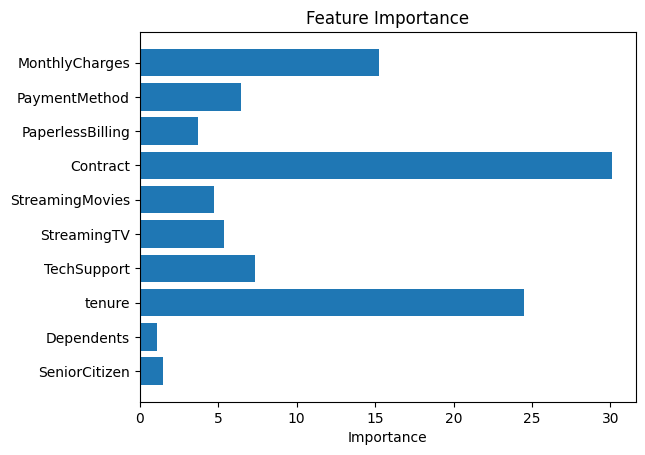

In [ ]:
fi = cb.get_feature_importance(train_pool_sel)
features = train_pool_sel.get_feature_names()

plt.barh(features, fi)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

## Подбор порога классификации и итоговые предсказания

In [ ]:
probs = cb.predict_proba(test_pool_sel)[:, 1]

best_f1 = 0
best_thresh = 0.5

for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred = (probs > thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"лучший порог по F1: {best_thresh}, F1: {best_f1}")

# Используем лучший порог
custom_pred = (probs > best_thresh).astype(int)

# Истинные метки
y_label = test_pool_sel.get_label()

# Метрики
recall = recall_score(y_label, custom_pred)
roc_auc = roc_auc_score(y_label, probs)
report = classification_report(y_label, custom_pred)

print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(report)

лучший порог по F1: 0.6099999999999998, F1: 0.66993006993007
recall: 0.7627388535031847
ROC AUC: 0.8607710684647691
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1697
           1       0.60      0.76      0.67       628

    accuracy                           0.80      2325
   macro avg       0.75      0.79      0.76      2325
weighted avg       0.82      0.80      0.80      2325



## Построение ROC-кривой

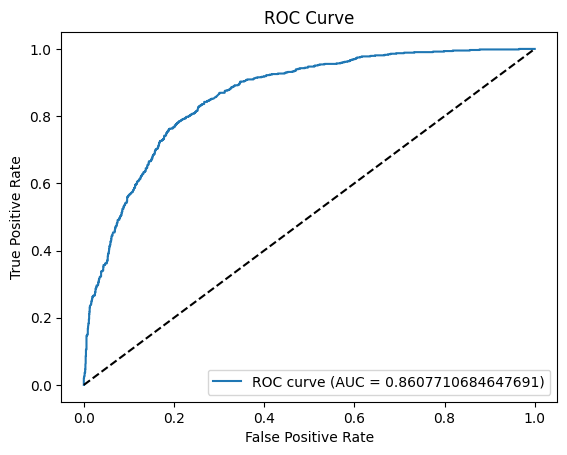

In [ ]:
fpr, tpr, thresholds = roc_curve(y_label, probs)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()